In [1]:
import importlib
import time
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.utils.extmath import randomized_svd

/home/travisharty/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline
dpi=400

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None, cbar_label=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    if cbar_label is None:
        plt.colorbar(im)
    else:
        plt.colorbar(im, label=cbar_label)
    plt.title(title)

In [5]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist


def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

In [6]:
dimension = 2**9
print(dimension)
rho0_l = 0.3
rho0_s = 0.009
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

# H = np.eye(dimension)[::2]
H = np.eye(dimension)
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [7]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


R = np.eye(obs_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.007731840725672
short variance:  1.0


Log10(condition):  19.311096827046455


Text(0.5,0.98,'Eigenvalues P_s')

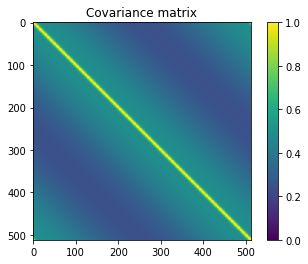

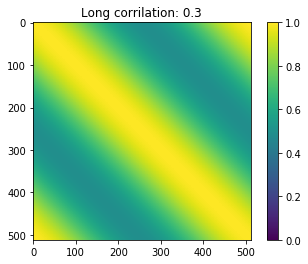

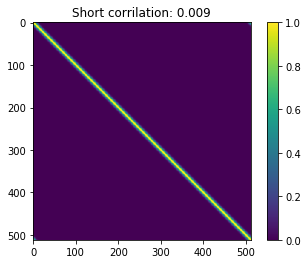

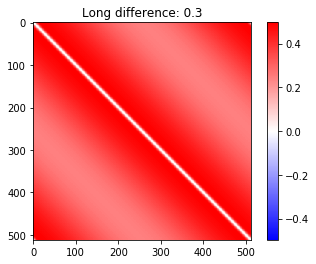

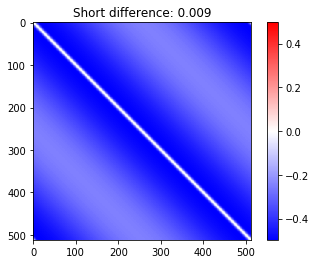

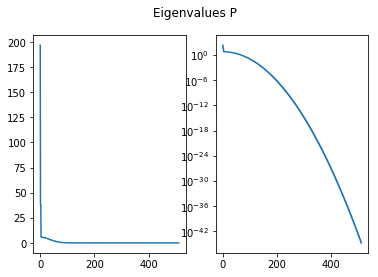

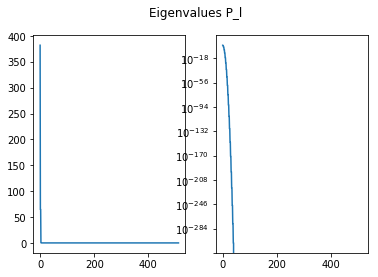

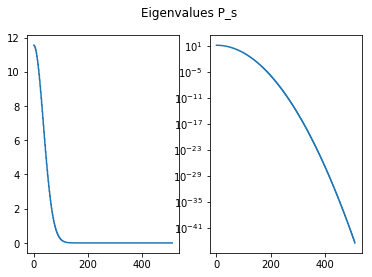

In [8]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

In [9]:
trans_mats = assimilate.transformation_matrices(
    H, P=P,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


In [10]:
trans_mats = assimilate.transformation_matrices(
    H, P=P_l,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_l'
    print(key)
    exec(key + '=val')

P_sqrt_l
P_inv_sqrt_l
R_sqrt_l
R_inv_sqrt_l
U_l
S_l
VT_l
H_l
Tx_l
Tx_inv_l
Ty_l
Ty_inv_l


In [11]:
trans_mats = assimilate.transformation_matrices(
    H, P=P_s,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_s'
    print(key)
    exec(key + '=val')

P_sqrt_s
P_inv_sqrt_s
R_sqrt_s
R_inv_sqrt_s
U_s
S_s
VT_s
H_s
Tx_s
Tx_inv_s
Ty_s
Ty_inv_s


In [12]:
ens_size = 40
ens_ens_size = 40
resample_size = None
mu = np.zeros(dimension)
ensemble = (
    assimilate.generate_ensemble(
        ens_size, mu, P_sqrt))
P_sample = np.cov(ensemble)

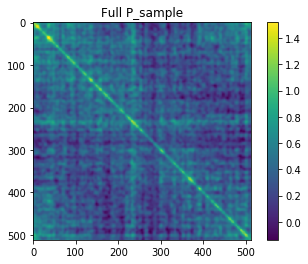

In [13]:
vmin = P_sample.min()
vmax = P_sample.max()
imshow(P_sample, vmin=vmin, vmax=vmax,
       title='Full P_sample')

In [14]:
P_sample_array = utilities.return_P_sample_array(
    ensemble=ensemble, ens_ens_size=ens_ens_size,
    resample_type='bootstrap')

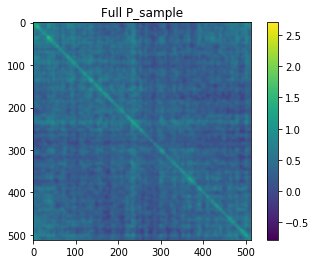

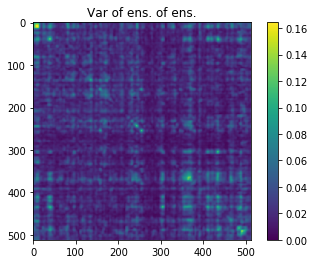

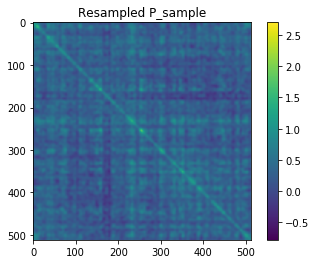

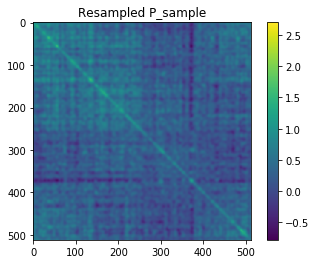

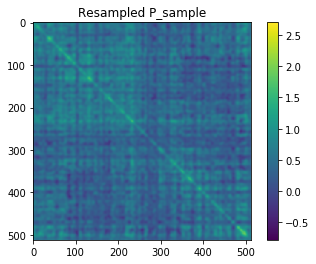

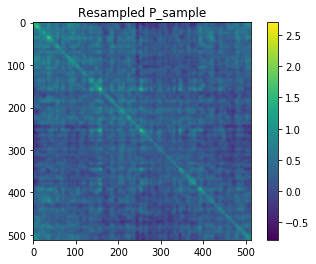

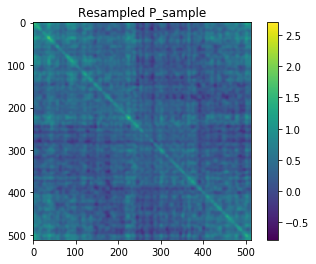

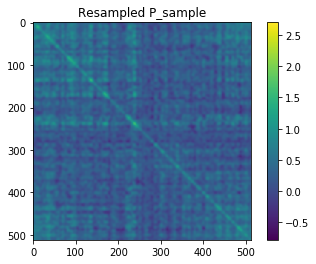

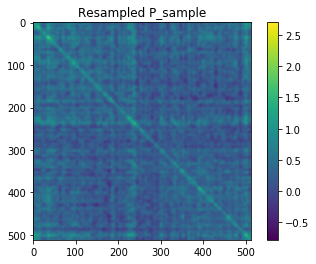

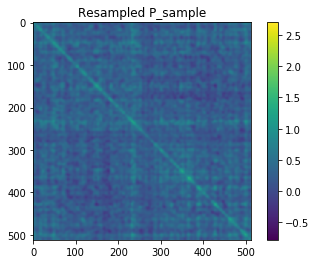

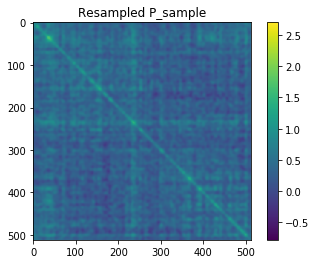

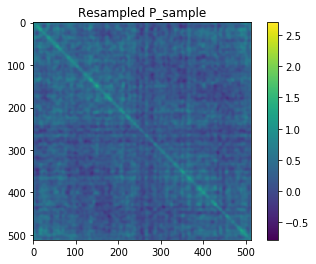

In [15]:
vmin = np.min([P_sample.min(),
               P_sample_array.min()])
vmax = np.max([P_sample.max(),
               P_sample_array.max()])
imshow(P_sample, vmin=vmin, vmax=vmax,
       title='Full P_sample')
imshow(np.var(P_sample_array, axis=-1),
       title='Var of ens. of ens.', vmin=0)
for ens_ens_num in range(min(ens_ens_size, 10)):
    imshow(P_sample_array[:, :, ens_ens_num],
           vmin=vmin, vmax=vmax,
           title='Resampled P_sample')

In [16]:
importlib.reload(utilities)
P_sample_array = utilities.return_P_sample_array(
    ensemble=ensemble, ens_ens_size=ens_ens_size,
    resample_type='bayes_bootstrap')

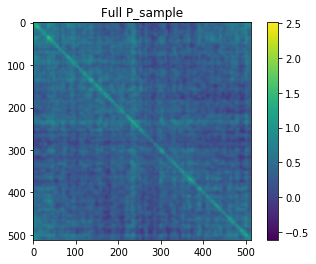

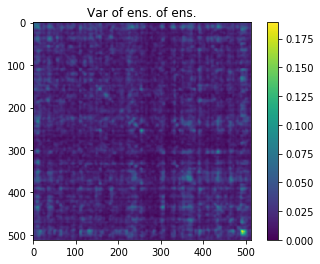

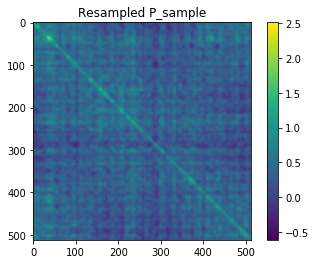

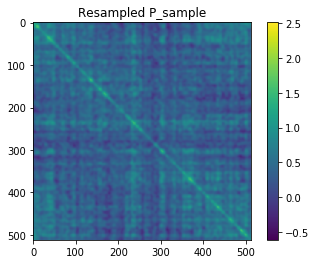

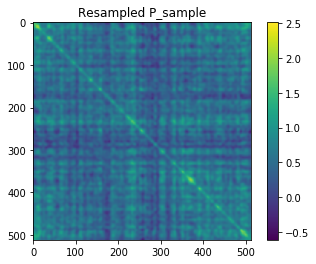

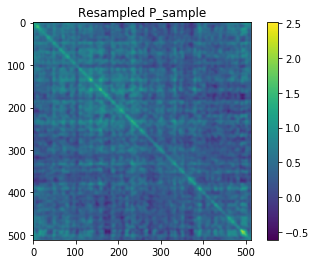

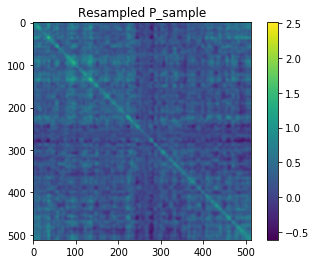

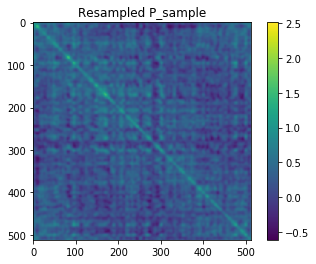

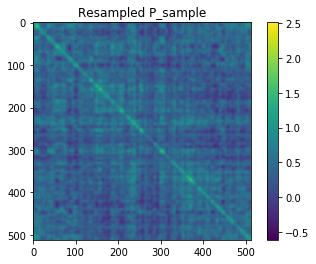

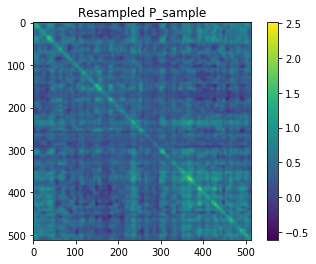

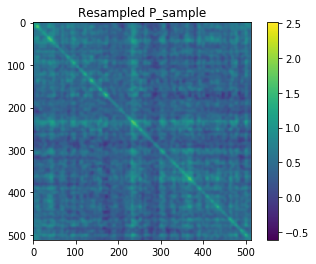

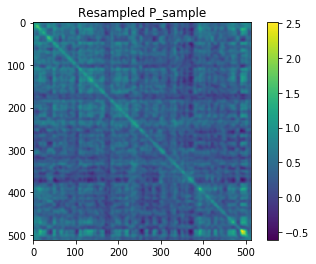

In [17]:
vmin = np.min([P_sample.min(),
               P_sample_array.min()])
vmax = np.max([P_sample.max(),
               P_sample_array.max()])
imshow(P_sample, vmin=vmin, vmax=vmax,
       title='Full P_sample')
imshow(np.var(P_sample_array, axis=-1),
       title='Var of ens. of ens.', vmin=0)
for ens_ens_num in range(min(ens_ens_size, 10)):
    imshow(P_sample_array[:, :, ens_ens_num],
           vmin=vmin, vmax=vmax,
           title='Resampled P_sample')